# Introduction

In this notebook we demonstrate spectral bias (the frequency principle)

This is the phenomena that neural networks tend to first learn low frequencies and then learn high frequencies.

To demonstrate this we compare two neural network architectures:

1. plain network
2. multi-scale network

We use amplitude of the $(\ell, m) = (2, 2)$ gravitational wave multipole from a highly precessing binary black hole system as an illustrative example of the kind of data we are attempting to model.

## Imports

In [1]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 16})

import numpy as np

import lal
import lalsimulation as lalsim

# from scrinet.interfaces import lalutils, rotations 
from wispy import lalutils, rotations 


from tensorflow.keras.utils import get_custom_objects
import pugna.activations
import pugna.layers
import pugna.models
import pugna.callbacks
import wispy.mscalev5
import wispy.model_utils
import wispy.callbacks
import wispy.utils
import wispy.logger
import wispy.resnet
import wispy
import subprocess
import datetime
import argparse
import sys
import os
import numpy as np
import tqdm
import tensorflow as tf
import tensorflow_addons as tfa

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.model_selection import train_test_split

## Generate target waveform

In [178]:
params = lalutils.gen_td_modes_wf_params(
    m1=100,
    m2=10,
    approximant=lalsim.SEOBNRv4P,
    S1x=0.99,
    S1y=0.,
    S2x=0.99,
    S2y=0.,
    f_min=12,
    f_ref=12,
    phiRef=1.2)

t_min = -1000
# t_min = -5000
times, hlms = lalutils.gen_td_modes_wf(params, eob_all_ell_2_modes=True, modes=[[2,2],[2,1]], t_min=t_min, t_max=110)


In [179]:
times.shape

(2463,)

Text(0.5, 0, 't [M]')

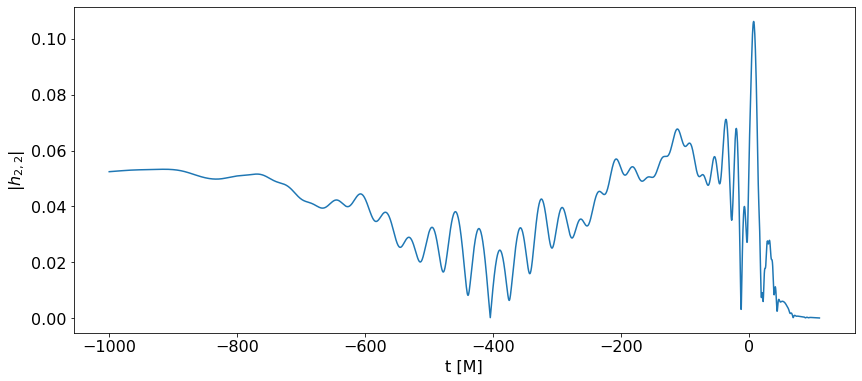

In [180]:
plt.figure(figsize=(14, 6))
plt.plot(times, np.abs(hlms[(2,2)]))

plt.ylabel(r"$|h_{2,2}|$")
plt.xlabel("t [M]")

Text(0.5, 0, 't [M]')

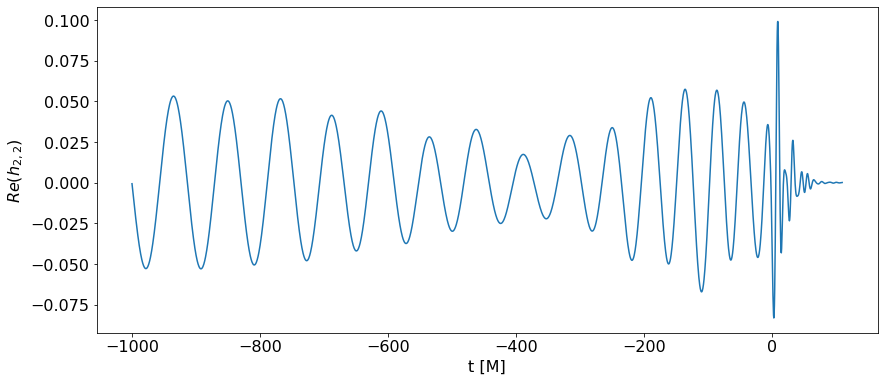

In [181]:
plt.figure(figsize=(14, 6))
plt.plot(times, np.real(hlms[(2,2)]))

plt.ylabel(r"$Re(h_{2,2})$")
plt.xlabel("t [M]")

## feature engineering

In [182]:
# scale times
times_scaler = MinMaxScaler(feature_range=(-1,0))
# times_scaler = MinMaxScaler(feature_range=(-1,1))
# times_scaler = MinMaxScaler(feature_range=(-0.1, 0.1))
# times_scaler = StandardScaler()
X_train = times_scaler.fit_transform(times[:,np.newaxis])

In [183]:
amp_scale_22 = np.abs(hlms[(2,2)]).max()
print(amp_scale_22)
y_train = {}
y_train['amp'] = np.abs(hlms[(2,2)])/amp_scale_22
y_train['amp'] = y_train['amp'][:, np.newaxis] / 10 # divide by 10 because the prior distribution of the network seems to be about 0.1...

0.10620956808412162


In [184]:
phi_22 = np.unwrap(np.angle(hlms[(2,2)]))
phase_scale_22 = np.abs(phi_22).max()
print(phase_scale_22)
y_train['phase'] = phi_22/phase_scale_22
y_train['phase'] = y_train['phase'][:, np.newaxis] / 10

47.915073143567724


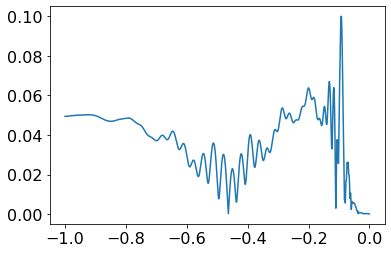

In [185]:
plt.figure()
plt.plot(X_train, y_train['amp'])

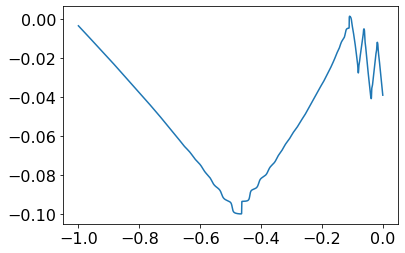

In [186]:
plt.figure()
plt.plot(X_train, y_train['phase'])

In [187]:
# y_train = np.abs(hlms[(2,2)])[:,np.newaxis]

## Multi-scale network fit

In [210]:
def run_model(X_train, y_train, epochs=1001, threshold=1e-8, batch_size=32, validation_data=None):

    # try scales: pow of 2
#     scales = 2**np.arange(0,11,2)
#     scales = [1,10,50]
    scales = [1,10,50,100]
#     scales = [1,10,50,100, 0.01]
#     scales = [1,5,10,50,100,500]
    # scales = [1, 2, 5, 10, 20, 50, 100, 500]
    n_scales = len(scales)
    n_blocks = [1] * n_scales
    layers_per_block = 3
    units = [128] * n_scales
#     units = [256] * n_scales
    activation = "relu"
#     activation = "tanh"
    scale_activation="s2relu"


    model_params_dict = dict(
        input_shape=1,
        output_shape=y_train.shape[1],
        units=units,
        activation=activation,
        scale_activation=scale_activation,
        n_blocks=n_blocks,
        scales=scales,
        layers_per_block=layers_per_block,
        scale_dimension=0,
        dtype=None,
        skip_connection=False,
        skip_connection_dense=False,
        final_dense=False,
    )
    
    model = wispy.mscalev5.build_model(**model_params_dict)
    
    callbacks = [
        tfa.callbacks.TQDMProgressBar(show_epoch_progress=False),
        wispy.callbacks.ThresholdCallback(threshold),
        tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-6, patience=200, factor=0.9, monitor='loss')
    ]
    
    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(1e-3))
    
#     return _ , model
    
    # history = model.fit(x=X_train, y=y_train['22_real'], epochs=201, verbose=0, batch_size=4000, callbacks=callbacks) 
    history = model.fit(x=X_train, y=y_train, epochs=epochs, verbose=0, batch_size=batch_size, callbacks=callbacks, validation_data=validation_data) 
    
    return history, model

In [211]:
X_train_fit, X_test_fit, y_train_fit, y_test_fit = train_test_split(X_train, y_train['amp'], test_size=0.33, random_state=42)

In [212]:
# %%time
# history_, model_ = run_model(X_train_fit, y_train_fit, epochs=5000, batch_size=X_train.shape[0]//2, validation_data=(X_test_fit, y_test_fit))

In [213]:
# # prior
# plt.plot(X_train, model_.predict(X_train)[:,0])

In [214]:
%%time
history, model = run_model(X_train_fit, y_train_fit, epochs=5000, batch_size=X_train.shape[0]//2, validation_data=(X_test_fit, y_test_fit))

Training:   0%|           0/5000 ETA: ?s,  ?epochs/s

CPU times: user 8min 31s, sys: 2min 53s, total: 11min 24s
Wall time: 3min 57s


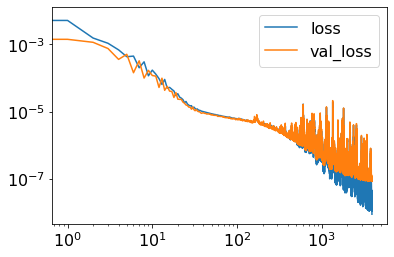

In [215]:
plt.figure()
plt.plot(history.history["loss"], label='loss')
plt.plot(history.history["val_loss"], label='val_loss')
plt.legend()
plt.yscale("log")
plt.xscale("log")

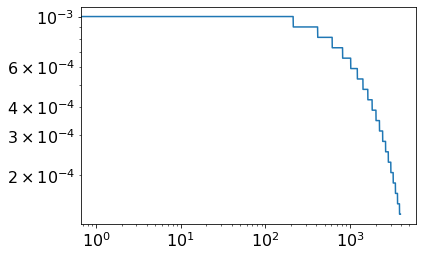

In [216]:
plt.figure()
plt.plot(history.history['lr'])
plt.yscale('log')
plt.xscale('log')

In [217]:
yhat = model.predict(X_train)

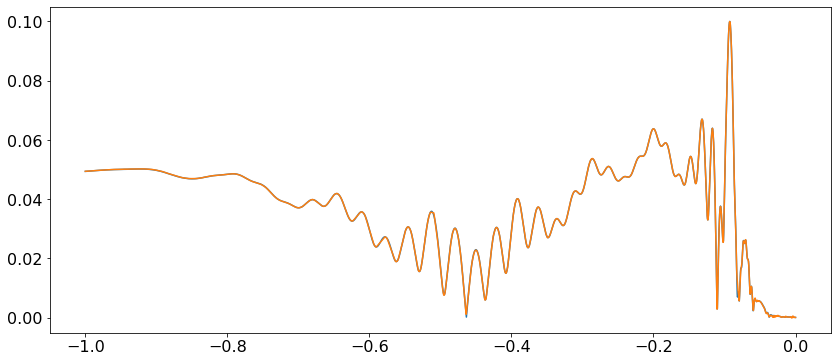

In [218]:
plt.figure(figsize=(14, 6))
plt.plot(X_train, y_train['amp'][:,0])
plt.plot(X_train, yhat[:,0])
# plt.xlim(-200.2, 100)
# plt.xlim(-0.12, 0.01)
# plt.yscale('log')

(-200.2, 100.0)

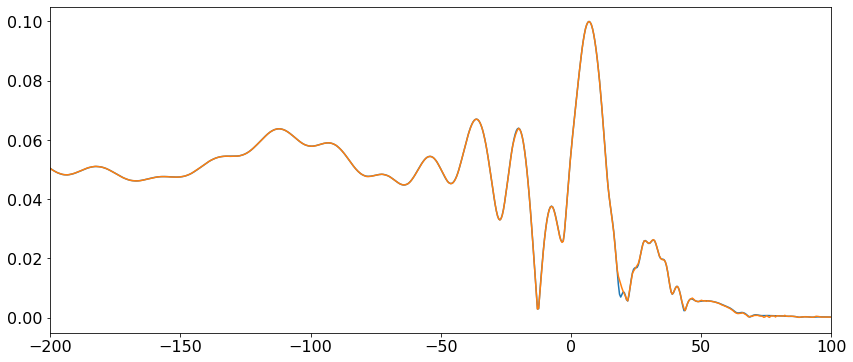

In [219]:
plt.figure(figsize=(14, 6))
plt.plot(times, y_train['amp'][:,0])
plt.plot(times, yhat[:,0])
plt.xlim(-200.2, 100)
# plt.xlim(-0.12, 0.01)
# plt.yscale('log')

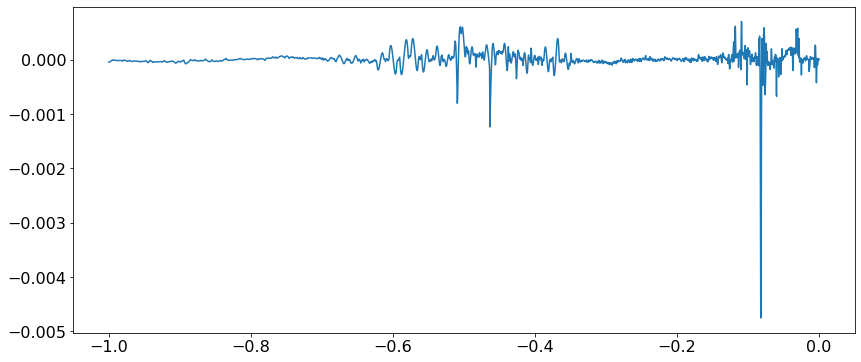

In [220]:
plt.figure(figsize=(14, 6))
plt.plot(X_train, y_train['amp'][:,0]-yhat[:,0])
# plt.xlim(-200.2, 100)
# plt.xlim(-0.12, 0.01)
# plt.yscale('log')

## phase

In [221]:
X_train_fit, X_test_fit, y_train_fit, y_test_fit = train_test_split(X_train, y_train['phase'], test_size=0.33, random_state=42)

In [222]:
%%time
history_phase, model_phase = run_model(X_train_fit, y_train_fit, epochs=5000, batch_size=X_train.shape[0]//2, validation_data=(X_test_fit, y_test_fit))

Training:   0%|           0/5000 ETA: ?s,  ?epochs/s

CPU times: user 10min 53s, sys: 3min 46s, total: 14min 40s
Wall time: 5min 2s


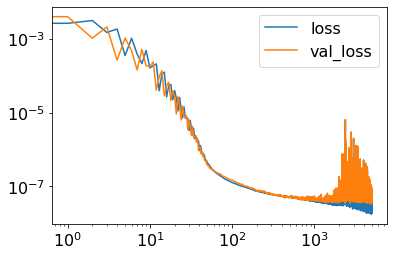

In [223]:
plt.figure()
plt.plot(history_phase.history["loss"], label='loss')
plt.plot(history_phase.history["val_loss"], label='val_loss')
plt.legend()
plt.yscale("log")
plt.xscale("log")

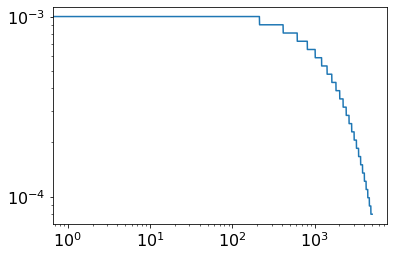

In [224]:
plt.figure()
plt.plot(history_phase.history['lr'])
plt.yscale('log')
plt.xscale('log')

In [225]:
yhat_phase = model_phase.predict(X_train)

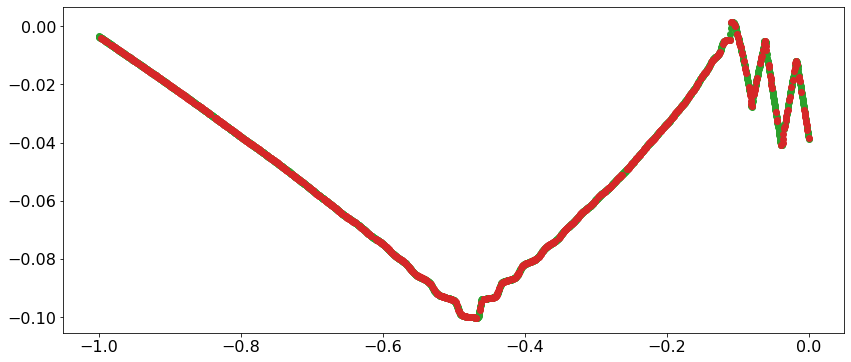

In [226]:
plt.figure(figsize=(14, 6))
plt.plot(X_train, y_train['phase'][:,0])
plt.plot(X_train, yhat_phase[:,0])


plt.plot(X_train_fit, model_phase.predict(X_train_fit)[:,0], 'o')
plt.plot(X_test_fit, model_phase.predict(X_test_fit)[:,0], 'o')

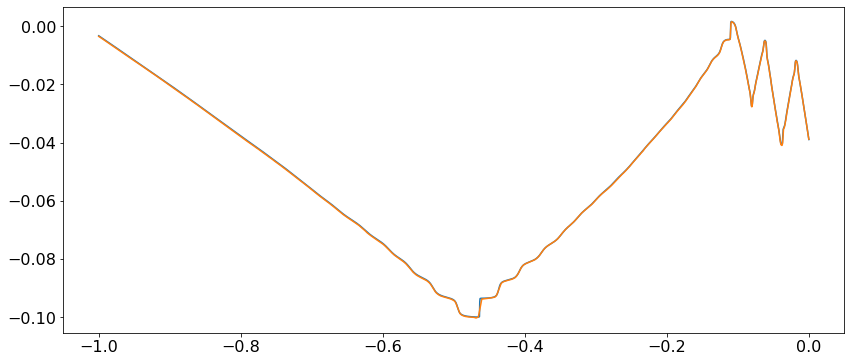

In [227]:
plt.figure(figsize=(14, 6))
plt.plot(X_train, y_train['phase'][:,0])
plt.plot(X_train, yhat_phase[:,0])


# plt.xlim(-200.2, 100)
# plt.xlim(-0.12, 0.01)
# plt.yscale('log')

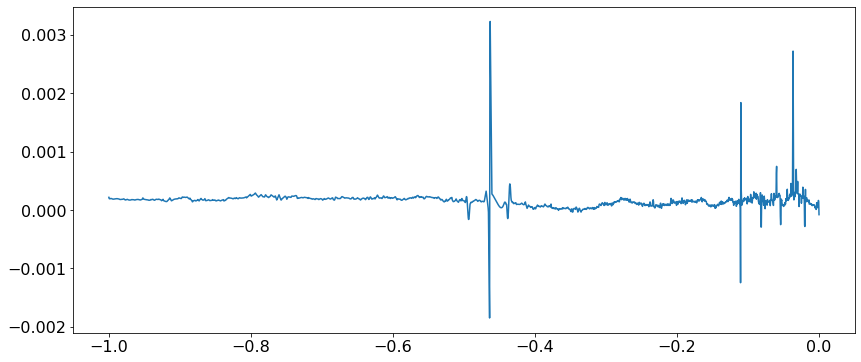

In [228]:
plt.figure(figsize=(14, 6))
plt.plot(X_train, y_train['phase'][:,0]-yhat_phase[:,0])
# plt.xlim(-200.2, 100)
# plt.xlim(-0.12, 0.01)
# plt.yscale('log')

## plot waveform

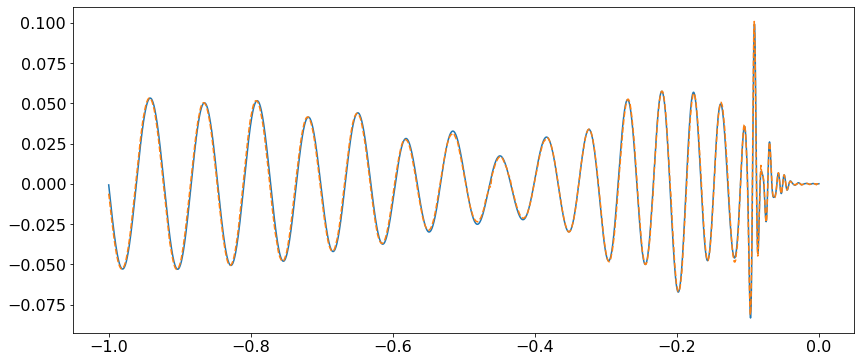

In [229]:
plt.figure(figsize=(14, 6))

y_train_h22 = y_train['amp'] * amp_scale_22 * 10 * np.exp(-1.j * y_train['phase'] * phase_scale_22 * 10)

y_hat_h22 = yhat * amp_scale_22 * 10 * np.exp(-1.j * yhat_phase * phase_scale_22 * 10)

# plt.plot(X_train, np.real(y_train_h22))

plt.plot(X_train, np.real(hlms[(2,2)]))

plt.plot(X_train, np.real(y_hat_h22), ls='--')

In [230]:
plt.figure(figsize=(14, 6))

y_train_h22 = y_train['amp'] * amp_scale_22 * 10 * np.exp(-1.j * y_train['phase'] * phase_scale_22 * 10)

y_hat_h22 = yhat * amp_scale_22 * 10 * np.exp(-1.j * yhat_phase * phase_scale_22 * 10)

# plt.plot(X_train, np.real(y_train_h22))

plt.plot(times, np.real(hlms[(2,2)]))

plt.plot(times, np.real(y_hat_h22), ls='--')


(-100.0, 100.0)

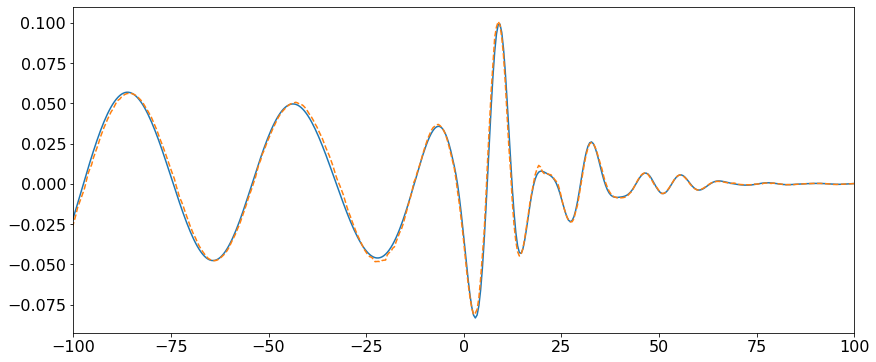

In [231]:
plt.figure(figsize=(14, 6))

y_train_h22 = y_train['amp'] * amp_scale_22 * 10 * np.exp(-1.j * y_train['phase'] * phase_scale_22 * 10)

y_hat_h22 = yhat * amp_scale_22 * 10 * np.exp(-1.j * yhat_phase * phase_scale_22 * 10)

# plt.plot(X_train, np.real(y_train_h22))

plt.plot(times, np.real(hlms[(2,2)]))

plt.plot(times, np.real(y_hat_h22), ls='--')

plt.xlim(-100, 100)